In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as  plt
from pandas.core.common import random_state
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

# Ignore warning messages 
import warnings
warnings.filterwarnings("ignore")

In [2]:
def random_sample_imputation(dataframe : pd.DataFrame, variable_name:str) -> None:
    """
    Imputes missing values in a column of a Pandas DataFrame
    using random sampling from the non-missing values.

    Args:
    - dataframe (pd.DataFrame): DataFrame containing the column to be imputed
    - variable_name (str): name of the column to be imputed

    Returns:
    - None
    """

    # Extract non-missing values from the specified column
    non_missing_values = dataframe[variable_name].dropna()

    # Generate random sample from non-missing values, with the same number of samples
    random_sample = non_missing_values.sample(dataframe[variable_name].isnull().sum(),
                                               random_state=0)

    # Assign the random sample to the missing values in the specified column
    random_sample.index = dataframe[dataframe[variable_name].isnull()].index
    dataframe.loc[dataframe[variable_name].isnull(), variable_name] = random_sample


In [3]:
def remove_null_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes null values from a pandas DataFrame by performing random sample imputation
    on all numerical features.

    Args:
        df (pandas.DataFrame): The DataFrame containing null values to be removed.

    Returns:
        pandas.DataFrame: The DataFrame with null values removed.
    """
    # Get list of numerical features in DataFrame
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
    
    # Perform random sample imputation on each numerical feature
    for feature in numerical_features:
        random_sample_imputation(df, feature)
    
    return df


In [4]:
def inter_quartile_range(df: pd.DataFrame, variable:str)-> pd.DataFrame:
    """
    This function computes the interquartile range (IQR) of a given variable in a dataframe,
    and removes any values that fall outside of the upper and lower limits.

    Args:
    - df: A pandas dataframe
    - variable: A string indicating the column name of the variable to be analyzed

    Returns:
    - A pandas dataframe with outliers removed from the specified variable
    """
    
    # Compute the first and third quartiles of the variable
    q1 = df[variable].quantile(0.5)
    q3 = df[variable].quantile(0.8)
    
    # Compute the IQR
    iqr = q3 - q1
    
    # Compute the lower and upper limits
    lower_bridge = df[variable].quantile(0.5) - (iqr * 1.5)
    upper_bridge = df[variable].quantile(0.8) + (iqr * 1.5)
    
    # Remove any values that fall outside of the upper and lower limits
    df.loc[df[variable] >= upper_bridge, variable] = upper_bridge
    df.loc[df[variable] <= lower_bridge, variable] = lower_bridge
    
    # Return the modified dataframe
    return df


In [5]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from the given dataframe.

    Args:
        df (pd.DataFrame): A pandas dataframe with numerical features.

    Returns:
        pd.DataFrame: A new dataframe with outliers removed from all numerical features.
    """
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
    for feature in numerical_features:
        df = inter_quartile_range(df, feature)
    return df


In [6]:
def run_model(i:int) -> dict:
    """
    Runs a random forest regression model on a specified column of a pandas DataFrame and returns the model and the RMSE.

    Args:
    i (int): The index of the target column to predict.

    Returns:
    dict: A dictionary containing the trained model and the RMSE value.
    """
    X = df.iloc[:,0].values.reshape(-1,1) # select the features as the first column of the DataFrame
    y = df.iloc[:,i].values # select the target column specified by the argument
    regressors = RandomForestRegressor() # initialize a random forest regressor
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # split the data into training and test sets
    regressors.fit(X,y) # train the model
    y_hat = regressors.predict(X) # make predictions on the test set
    rmse= np.sqrt(mean_squared_error(y, y_hat)) # calculate the RMSE
    return {
        'model':regressors, # return the trained model
        'rmse':rmse # return the RMSE
    }

In [7]:
def plot_sns(df: pd.DataFrame) -> None:
    """
    Plot seaborn boxplots for a given DataFrame.
    
    Args:
    - df: a pandas DataFrame to be plotted. It should have numeric values in its columns.
    
    Returns:
    - None
    """
    
    # Set the size of the plot
    plt.figure(figsize=(16,5))
    
    # Melt the dataframe to convert it from wide to long format for plotting
    df_melted = pd.melt(df.iloc[:,2:])
    
    # Create a boxplot using seaborn
    my_plot = sns.boxplot(x='variable', y='value', data=df_melted)
    
    # Rotate the x-axis tick labels for better readability
    my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
    
    # No explicit return value, since the function plots the data directly
    return None

In [8]:
def show_null_values(df: pd.DataFrame) -> None:
    """
    Plot a bar chart of the count of null values for each column of a pandas DataFrame.
    
    Args:
    - df: a pandas DataFrame to be plotted.
    
    Returns:
    - None
    """
    
    # Count the null values for each column of the dataframe
    data = df.isnull().sum()
    
    # Create a new figure and axis for the bar chart
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    # Set the y-axis label
    ax.set_ylabel('count')
    
    # Rotate the x-axis tick labels for better readability
    plt.xticks(rotation='vertical')
    
    # Create a bar chart of the null value counts for each column
    ax.bar(df.columns, data)
    
    # Show the plot
    plt.show()
    
    # No explicit return value, since the function plots the data directly
    return None


In [9]:
df = pd.read_csv('train.csv') # load the DataFrame from a CSV file or another data source

In [10]:
# Extract the first 12 months from the 'MONTH' column of the DataFrame as a list
month_list = df.MONTH.iloc[:12,].tolist()

# Create a dictionary that maps integer values to months using the 'month_list' as values
inverse_transform = {x: y for x, y in enumerate(month_list)}

# Create a dictionary that maps months to integer values using the 'month_list' as keys
transform = {y: x for x, y in enumerate(month_list)}

# Apply the 'transform' dictionary to the 'MONTH' column of the DataFrame
df['MONTH'] = df['MONTH'].apply(lambda x: transform[x])

# Drop the 'YEAR' column from the DataFrame along the columns axis (axis=1)
df.drop('YEAR', axis=1, inplace=True)


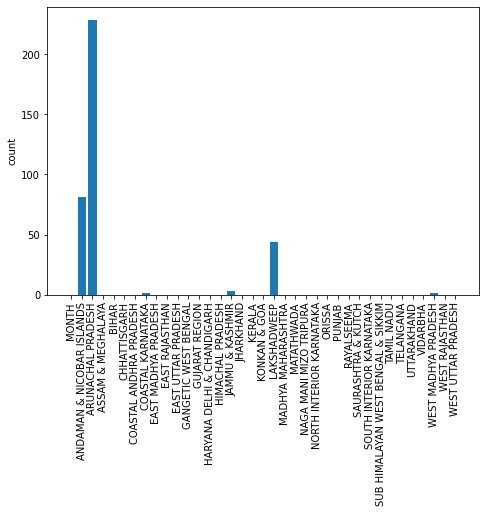

In [11]:
show_null_values(df)

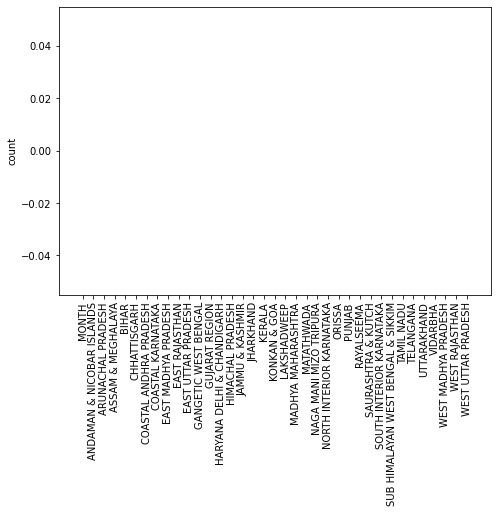

In [12]:
df = remove_null_values(df)
show_null_values(df)

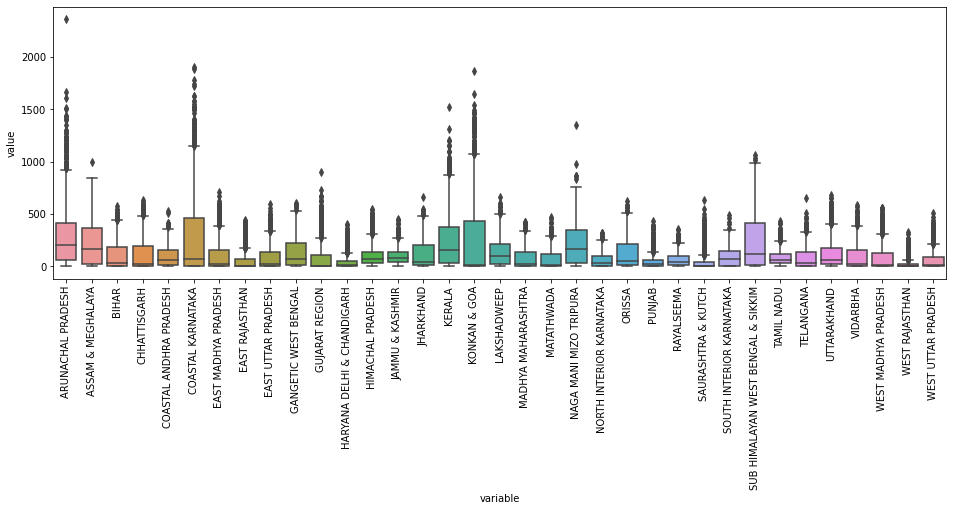

In [13]:
plot_sns(df);

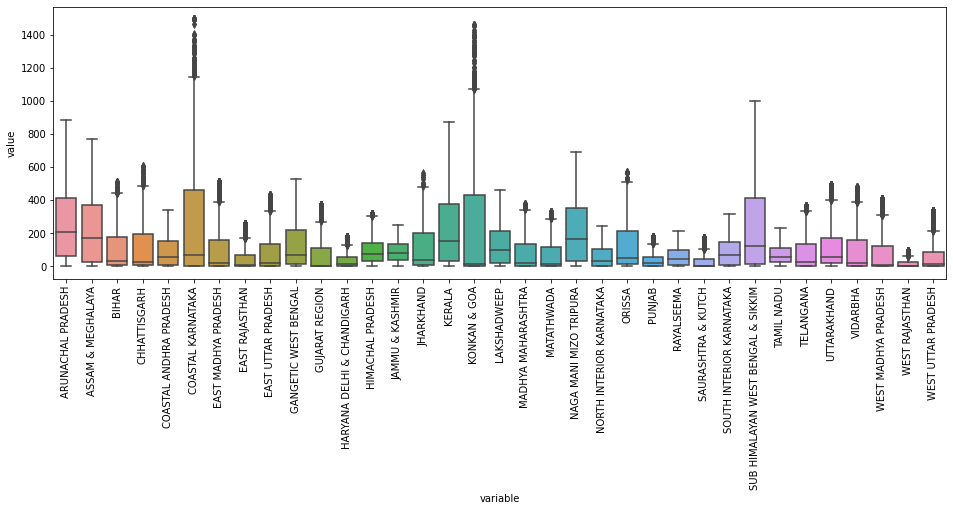

In [14]:
df = remove_outliers(df)
plot_sns(df);

In [15]:
model_run_df = pd.DataFrame(columns = ['range'])
model_run_df['range'] = [i for i in range(1,37)]
model_run_df['output'] = model_run_df['range'].apply(lambda x : run_model(x));

In [16]:
tmp_ = pd.DataFrame(list(model_run_df['output']))

In [17]:
tmp_ = pd.DataFrame(list(model_run_df['output']))
model_run_df['rmse'] = tmp_['rmse']
model_run_df['model'] = tmp_['model']
model_run_df.drop('output',axis = 1,inplace = True)

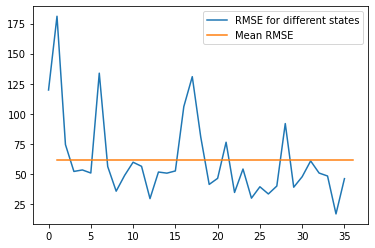

In [18]:
plt.plot(model_run_df.rmse,label = "RMSE for different states")
plt.plot(range(1,37),np.ones(36)*model_run_df.rmse.mean(),label = "Mean RMSE")
plt.legend()
plt.show()

In [19]:
model_run_df.rmse.mean()

61.698968611302575

In [20]:
prediction = model_run_df['model'].apply(lambda regressor : [regressor.predict(np.array(i).reshape(-1, 1)).squeeze() for i in inverse_transform.keys()])
prediction = pd.DataFrame(list(prediction))

In [21]:
prediction = prediction.T.reset_index()
assert len(prediction.columns) == len(df.columns)
prediction.columns = df.columns
prediction.MONTH = prediction.MONTH.apply(lambda x :inverse_transform[x])

In [22]:
prediction.to_csv('submission.csv',index=False)

In [23]:
prediction.head()

,MONTH,ANDAMAN & NICOBAR ISLANDS,ARUNACHAL PRADESH,ASSAM & MEGHALAYA,BIHAR,CHHATTISGARH,COASTAL ANDHRA PRADESH,COASTAL KARNATAKA,EAST MADHYA PRADESH,EAST RAJASTHAN,...,SAURASHTRA & KUTCH,SOUTH INTERIOR KARNATAKA,SUB HIMALAYAN WEST BENGAL & SIKKIM,TAMIL NADU,TELANGANA,UTTARAKHAND,VIDARBHA,WEST MADHYA PRADESH,WEST RAJASTHAN,WEST UTTAR PRADESH
0,JAN,58.36907586642575,70.34293147020011,16.804897630201722,13.699499029470184,14.168462335024417,7.5048043233934285,7.524682053101138,19.074129713529956,6.566434954731875,...,1.1367780367623253,2.908836165192597,13.942849960804805,24.366689625518774,7.707242892682911,53.79725683773073,10.452401545346323,9.095676581456507,3.3934756141151756,17.57496373834028
1,FEB,36.40462775826703,124.73228107458402,31.41234011642458,14.5825607780733,19.455733952096146,13.077488592544544,1.5117640438395987,18.66455487126719,5.424768136663105,...,1.6181922466405447,4.3082965157663695,23.26922985223289,13.954510531817759,9.639064819510198,63.47914220019832,12.168303082776319,7.591088536648994,5.018446563888933,18.134326840417476
2,MAR,49.161874955867916,190.9035040132108,79.57586713496853,10.16450049356563,15.186643201443562,13.432428066151239,6.379725961607113,13.478368383522172,4.192363454361607,...,1.3330108876418358,9.13270670178459,42.84216661517956,19.36740919038095,12.129141610032589,56.58507928208909,11.233056400612192,4.654524432530586,3.870693269994457,10.93181158782921
3,APR,83.72989161076357,260.01264425123844,202.39211854922215,16.70672098686849,16.503839712996793,26.415899695136837,30.31652191818112,7.18532161068353,2.992659794612051,...,1.1152214836038055,41.55484199370244,110.63560192482294,44.661200445168,17.922230290168113,35.49863573087951,9.514997318776558,2.283122808814934,3.4851521374985226,6.115973235924319
4,MAY,346.7791154085646,345.6260887396147,343.65848461857246,53.225919491430666,21.280136234110884,61.75622825657803,122.21154425152153,9.136338488811457,9.971536421154463,...,4.61626004124466,92.27863948419308,268.53151415112063,69.6068970516227,25.502798816591568,55.911423438004725,11.566975071280586,7.731310433241383,9.517536967702034,12.395711456182749
